In [19]:
import os
import sys

sys.path.append("..")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import HH4b.utils as utils
import HH4b.plotting as plotting
from HH4b.postprocessing.postprocessing import Region, weight_shifts
from HH4b.utils import ShapeVar, CUT_MAX_VAL
from HH4b.hh_vars import samples, data_key, bg_keys, sig_keys
from sklearn.metrics import roc_curve, auc

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})

In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [4]:
year = "2022EE"

samples_year = samples[year].copy()

MAIN_DIR = "/ceph/cms/store/user/dprimosc/bbbb/skimmer"
# this is the directory to the files

tag = "24Sep3_v12_private_signal"
path_to_dir = f"{MAIN_DIR}/{tag}/"

# define dictionary with directories of files (this can be configured in a yaml file later in the script)
sig_keys = ["hh4b"]
for key in list(samples_year.keys()):
    if key not in ["qcd", "ttbar"] + sig_keys:
        del samples_year[key]

sample_dirs = {path_to_dir: samples_year}

# make plot and template directory
date = "24Sep6"  # date of plotting
plot_dir = f"{MAIN_DIR}/plots/PostProcessing/{date}/{year}"
template_dir = f"templates/{date}/"  # why needed?
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {template_dir}/cutflows/{year}")

In [5]:
# Checking contents of parquet files
def examine_parquet_files(dir_path):

    # add ticker to only print contents of first file
    ticker = 0
    for file_name in os.listdir(dir_path):
        if ticker != 0:
            break

        if file_name.endswith(".parquet"):
            ticker += 1

            file_path = os.path.join(dir_path, file_name)

            try:
                # Read the parquet file into a DataFrame
                df = pd.read_parquet(file_path)

                # Display file information
                print(f"\nContents of {file_path}:")
                print("Columns:")
                for column in df.columns:
                    if column[1] == 0:
                        # print column and number of entries
                        print(f"{column[0]}: {df[column[0]].shape[1]}")

            except Exception as e:
                print(f"Error reading {file_path}: {e}")


test_directory = "/ceph/cms/store/user/dprimosc/bbbb/skimmer/24Sep3_v12_private_signal/2022EE/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV/parquet"
print(test_directory)
examine_parquet_files(test_directory)

/ceph/cms/store/user/dprimosc/bbbb/skimmer/24Sep3_v12_private_signal/2022EE/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV/parquet

Contents of /ceph/cms/store/user/dprimosc/bbbb/skimmer/24Sep3_v12_private_signal/2022EE/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV/parquet/out_3.parquet:
Columns:
GenHiggsEta: 2
GenHiggsPhi: 2
GenHiggsMass: 2
GenHiggsPt: 2
GenbEta: 4
GenbPhi: 4
GenbMass: 4
GenbPt: 4
ak8FatJetHiggsMatch: 2
ak8FatJetHiggsMatchIndex: 2
ak8FatJetNumBMatchedH1: 2
ak8FatJetNumBMatchedH2: 2
ak8FatJetMaxdRH1: 2
ak8FatJetMaxdRH2: 2
bbFatJetEta: 2
bbFatJetPhi: 2
bbFatJetMass: 2
bbFatJetPt: 2
bbFatJetMsd: 2
bbFatJetPNetTXbb: 2
bbFatJetPNetTXjj: 2
bbFatJetPNetTQCD: 2
bbFatJetPNetQCD1HF: 2
bbFatJetPNetQCD2HF: 2
bbFatJetPNetQCD0HF: 2
bbFatJetPNetMass: 2
bbFatJetPNetMassRaw: 2
bbFatJetTau3OverTau2: 2
bbFatJetrawFactor: 2
bbFatJetMatchedGenJetPt: 2
bbFatJetPNetMassLegacy: 2
bbFatJetPNetTXbbLegacy: 2
bbFatJetPNetPXbbLegacy: 2
bbFatJetPNetPQCDLegacy: 2
bbFatJetPNetPQCDbL

In [12]:
# filters, currently just a placeholder value to apply no real filter
filters = [
    [
        ("('weight', '0')", ">=", 0),
    ],
]

# columns to load
# TODO figure out why HiggsMatch columns don't load
load_columns = [
    ("weight", 1),
    ("ak8FatJetPNetTXbb", 2),
    # ("ak8FatJetHiggsMatchIndex",2),
    # ("ak8FatJetNumBMatchedH1",2),
    # ("ak8FatJetNumBMatchedH2",2),
]

# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")

# save cutflow as pandas table
# TODO: check this is running correctly
cutflow = pd.DataFrame(index=list(samples_year.keys()))

# dictionary that will contain all information (from all samples)
events_dict = {}
for input_dir, samples_dict in sample_dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(
            input_dir,
            samples_dict,
            year,
            filters=filters,
            columns=columns,
            reorder_txbb=False,
            variations=False,
            # columns_mc=utils.format_columns(load_columns_mc),
        ),
    }

utils.add_to_cutflow(events_dict, "Preselection", "finalWeight", cutflow)
print("\n", cutflow)

# TODO: why are event numbers astronomically large

Loading QCD_HT-1200to1500
Loaded QCD_HT-1200to1500                                 : 13715549 entries
Loading QCD_HT-100to200
Loaded QCD_HT-100to200                                   : 8 entries
Loading QCD_HT-1500to2000
Loaded QCD_HT-1500to2000                                 : 15374273 entries
Loading QCD_HT-600to800
Loaded QCD_HT-600to800                                   : 536811 entries
Loading QCD_HT-200to400
Loaded QCD_HT-200to400                                   : 30 entries
Loading QCD_HT-2000
Loaded QCD_HT-2000                                       : 18578670 entries
Loading QCD_HT-800to1000
Loaded QCD_HT-800to1000                                  : 3896199 entries
Loading QCD_HT-400to600
Loaded QCD_HT-400to600                                   : 31979 entries
Loading QCD_HT-1000to1200
Loaded QCD_HT-1000to1200                                 : 9059221 entries
Loading TTto4Q
Loaded TTto4Q                                            : 5665143 entries
Loading GluGlutoHHto4B_kl-1

/home/users/dprimosc/micromamba/envs/hh4b/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [17]:
jet = 1  # second jet
sig_key = "hh4b"
bg_keys = ["qcd", "ttbar"]
# bg_skip = 1

y_true = np.concatenate(
    [
        np.ones(len(events_dict["hh4b"])),
        np.zeros(np.sum(len(events_dict[bg_key]) for bg_key in bg_keys)),
    ]
)
# print(y_true[np.sum(sig_cut):])

weights = np.concatenate(
    [events_dict[sig_key]["finalWeight"]]
    + [events_dict[bg_key]["finalWeight"] for bg_key in bg_keys],
)

scores = np.concatenate(
    [events_dict[sig_key]["ak8FatJetPNetTXbb"][jet]]
    + [events_dict[bg_key]["ak8FatJetPNetTXbb"][jet] for bg_key in bg_keys],
)

/tmp/ipykernel_2467648/4207022153.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.zeros(np.sum(len(events_dict[bg_key]) for bg_key in bg_keys)),


In [20]:
fpr, tpr, thresholds = roc_curve(y_true, scores, sample_weight=weights)
roc = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds}

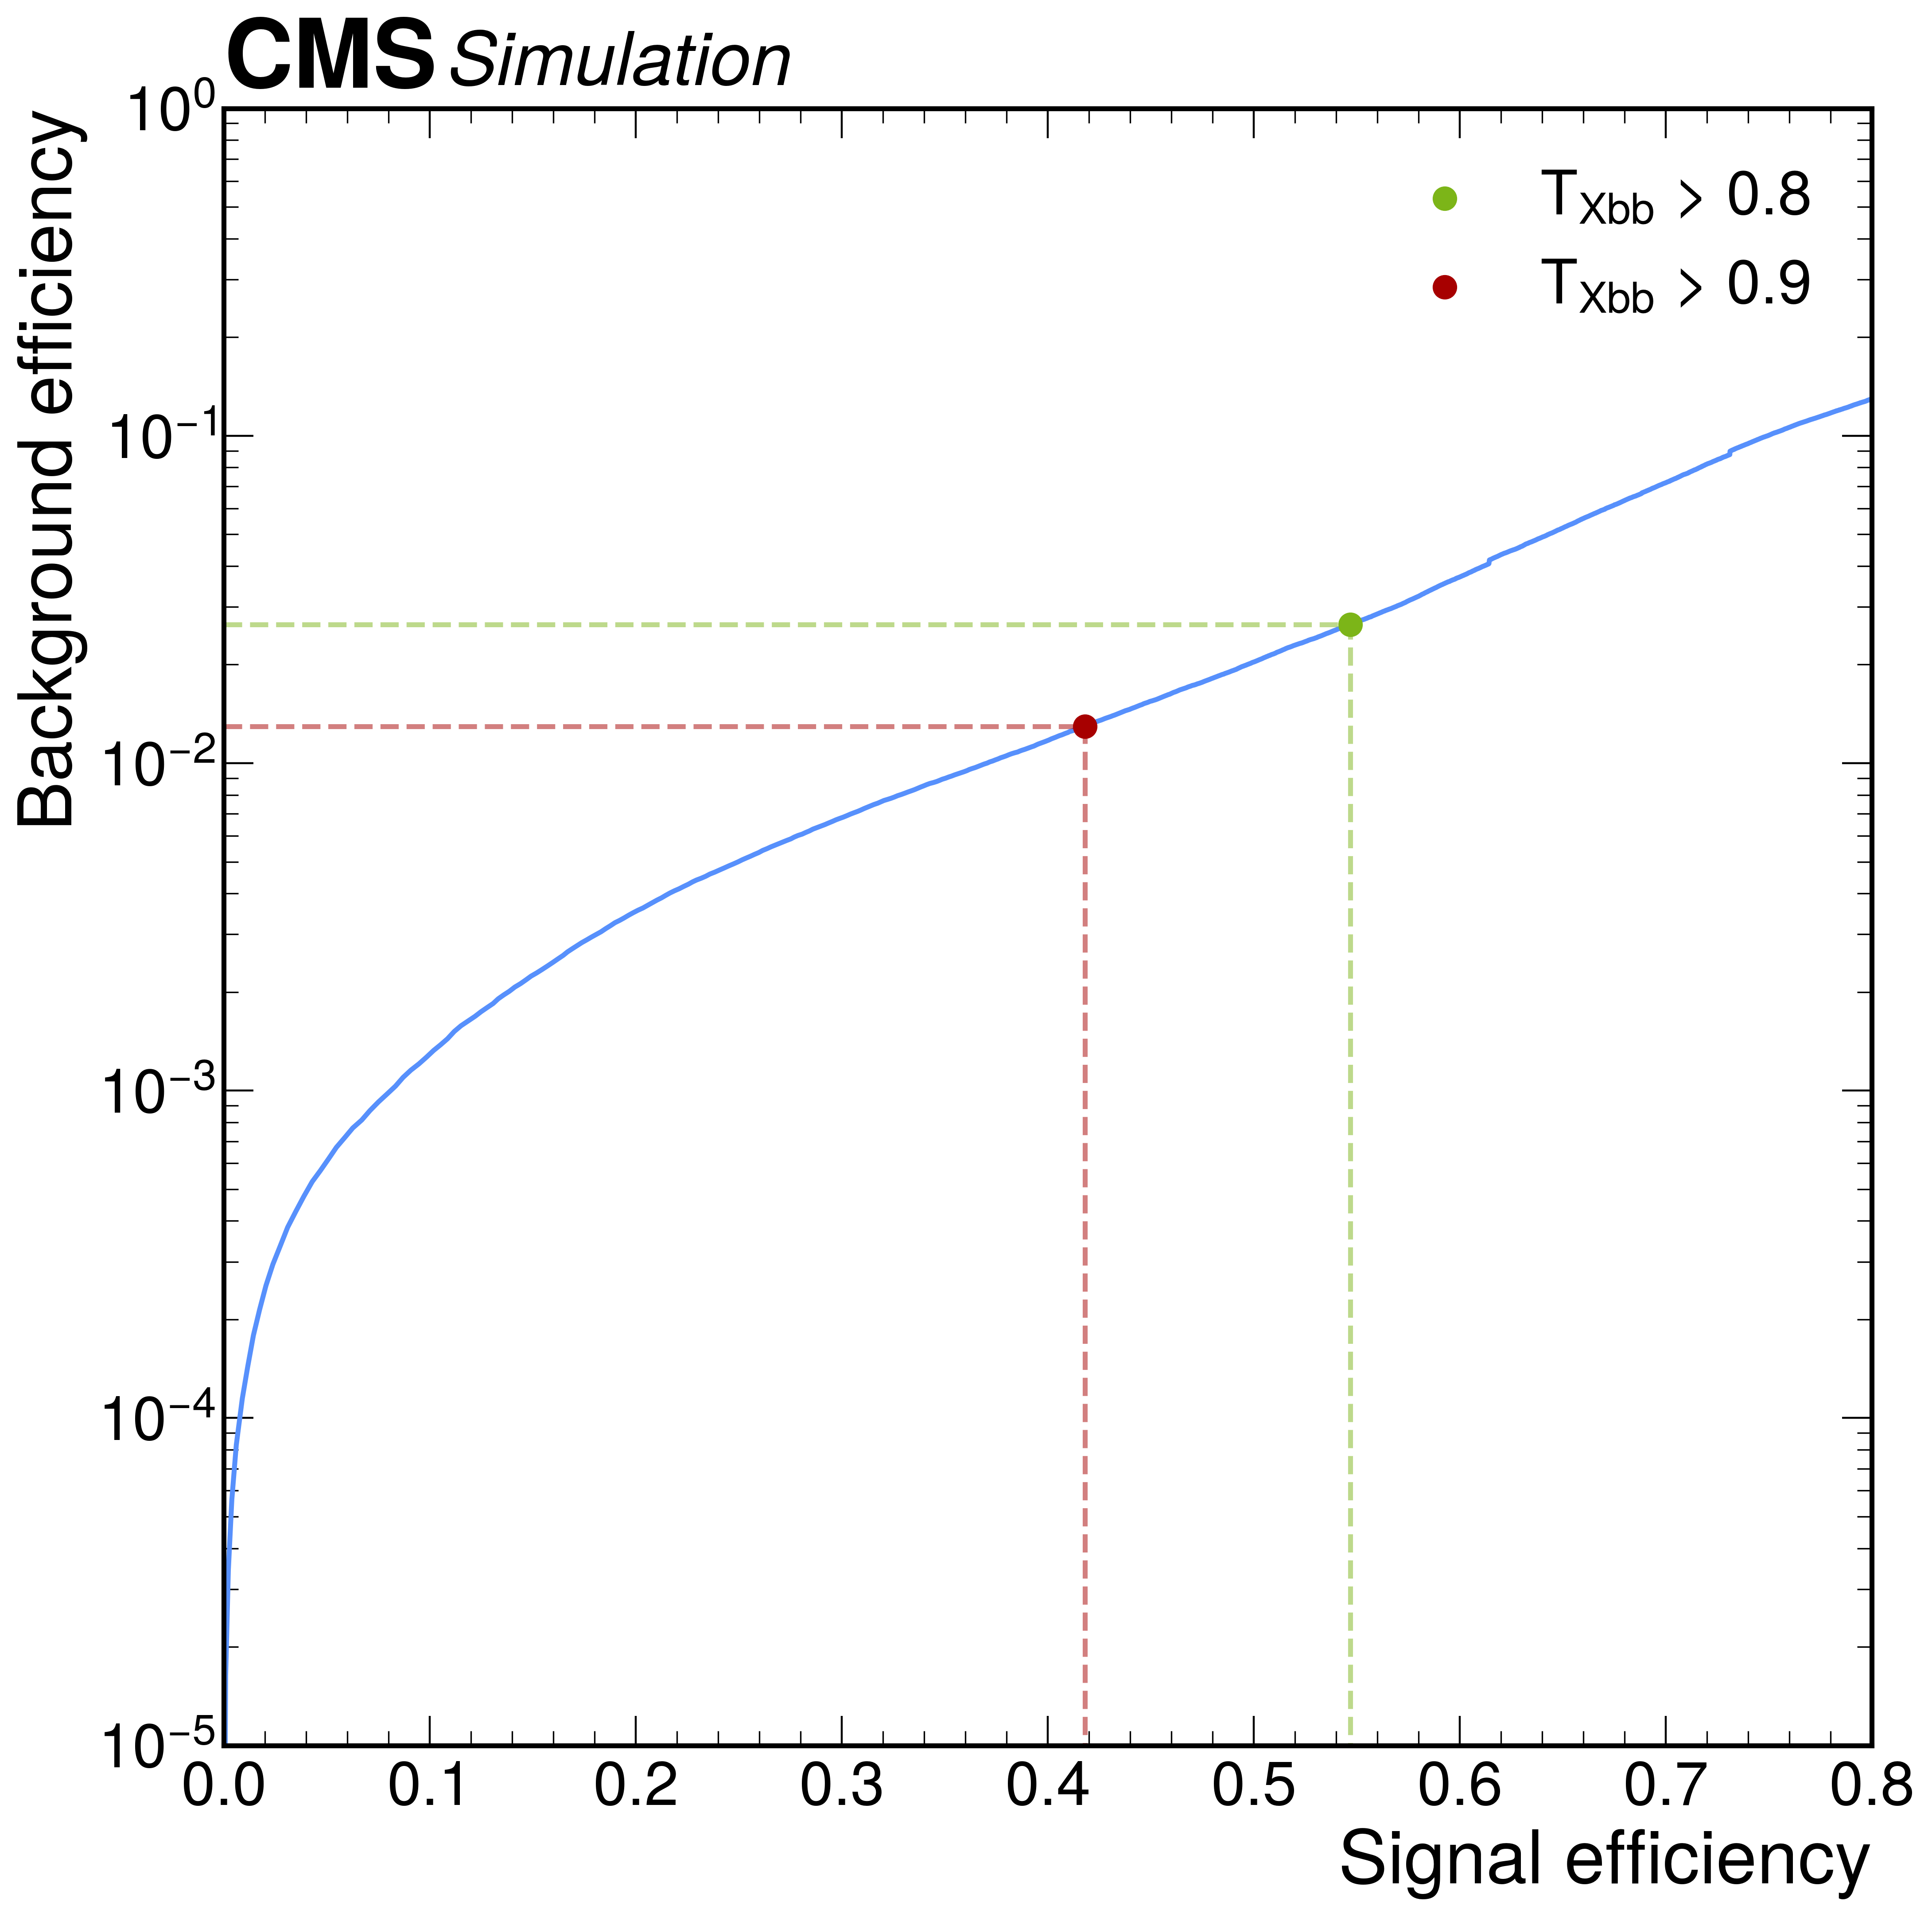

In [22]:
plotting.ROCCurve(
    roc,
    xlim=[0, 0.8],
    ylim=[1e-5, 1],
    thresholds=[0.8, 0.9],
    show=True,
    plot_dir=plot_dir,
    name=f"ak8FatJet{jet+1}ROC",
)